In [14]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set_theme('notebook')
import matplotlib as mpl
import progressbar
import pickle
from scipy.signal import find_peaks, peak_prominences
from datetime import datetime


#data_dir = os.getcwd() + '\\2-3_Quarter02-2118AMPM004-09-29-2021\\'
#die = 'Die_25\\'

datafile = 'grid_scan_one_row_0_col_2_VW_sweep.pkl'

#filename=data_dir+die+datafile
filename = datafile

data = pickle.load( open(filename,"rb"))


In [15]:
def plot_VW(data, 
                chan = 1, 
                zoom_span = 5,
                prominence = 4.5,
                fit_order = 8,
                fsr = 15,
                ideal_peak_wl = 1550,
                save = False):
        
        
        fig = plt.figure( figsize = (9,7), dpi = 500 )
        widths = [1, 1, 0.1]
        heights = [1, 1]
        spec = fig.add_gridspec(ncols=3, 
                                 nrows=2, 
                                 width_ratios=widths,
                                 height_ratios=heights)
        
        
        
        
        colors = plt.cm.viridis(np.linspace(0,1,len(data['voltages'])))
        a0 = fig.add_subplot(spec[0,:-1]) #raw spectra
        a01 = fig.add_subplot(spec[:,2]) #voltage applied
        a1 = fig.add_subplot(spec[1,0]) #IV curve
        a2 = fig.add_subplot(spec[1,1]) #zoom window
        
        
        wl = np.array(data['wavelengths'][0])
        pw = np.array(data['powers'][0][chan - 1])
        
        ridx = np.isfinite(wl) & np.isfinite(pw)

        baseline = np.poly1d(np.polyfit(wl[ridx],pw[ridx],fit_order))
        
        pw_bs = pw - baseline(wl) + max(baseline(wl)) - max(pw)
        wl_per_args = wl[1] - wl[0]
        peaks ,_ = find_peaks(-pw_bs, prominence = prominence, distance = int(fsr/wl_per_args))
        
        idx = np.abs(wl[peaks] - ideal_peak_wl).argmin()
        center_peak = peaks[idx]
        
        span = int(0.5*zoom_span/wl_per_args)
        start_zoom, stop_zoom = center_peak - span, center_peak + span
        
        for i in range(len(data['wavelengths'])):
            wl = np.array(data['wavelengths'][i])
            pw = np.array(data['powers'][i][chan - 1])
            
            a0.plot(wl, pw, 
                    lw = 0.5, 
                    color = colors[i])
        
            a2.plot(wl[start_zoom:stop_zoom], 
                    pw[start_zoom:stop_zoom],
                    color = colors[i])
            
        
        norm = mpl.colors.Normalize(vmin=np.min(data['voltages']), 
                                    vmax=np.max(data['voltages']))
        cbar = a01.figure.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'),
                                   ax=a01, 
                                   fraction=1, pad=0.04,
                                   extend='both', 
                                   label = 'Voltage Applied')
        
        a01.axis('off')
        
        a0.set_title('Raw Spectra for Dev: ' + data['name'] + ' Measured: ' + data['datetime'].strftime('%b %d, %Y at %H:%M') )
        a0.set_xlabel('Wavelength (nm)')
        a0.set_ylabel('Power (dBm)')
        a0.xaxis.set_major_locator(MaxNLocator(18)) 
        
        a2.set_title('Zoom Window to Peak Nearest {:} nm'.format(ideal_peak_wl))
        a2.set_xlabel('Wavelength (nm)')
        a2.set_ylabel('Power (dBm)')
        
                
        a1.plot(data['voltages'], data['currents']*1e3, '-o', color = 'purple')
        a1.set_title('IV Curve')
        a1.set_xlabel('Voltage (V)')
        a1.set_ylabel('Current (mA)')
        
        fig.tight_layout()
        if save:
            fig.savefig(directory + data['name'] + '_VWSweep.png', 
                        dpi = 500)
            plt.close()
        else:
            plt.show()

<ipython-input-25-2ca22f3c9988>:1: RankWarning: Polyfit may be poorly conditioned
  plot_VW(data, fit_order=8, ideal_peak_wl = 1590, zoom_span=0.75)


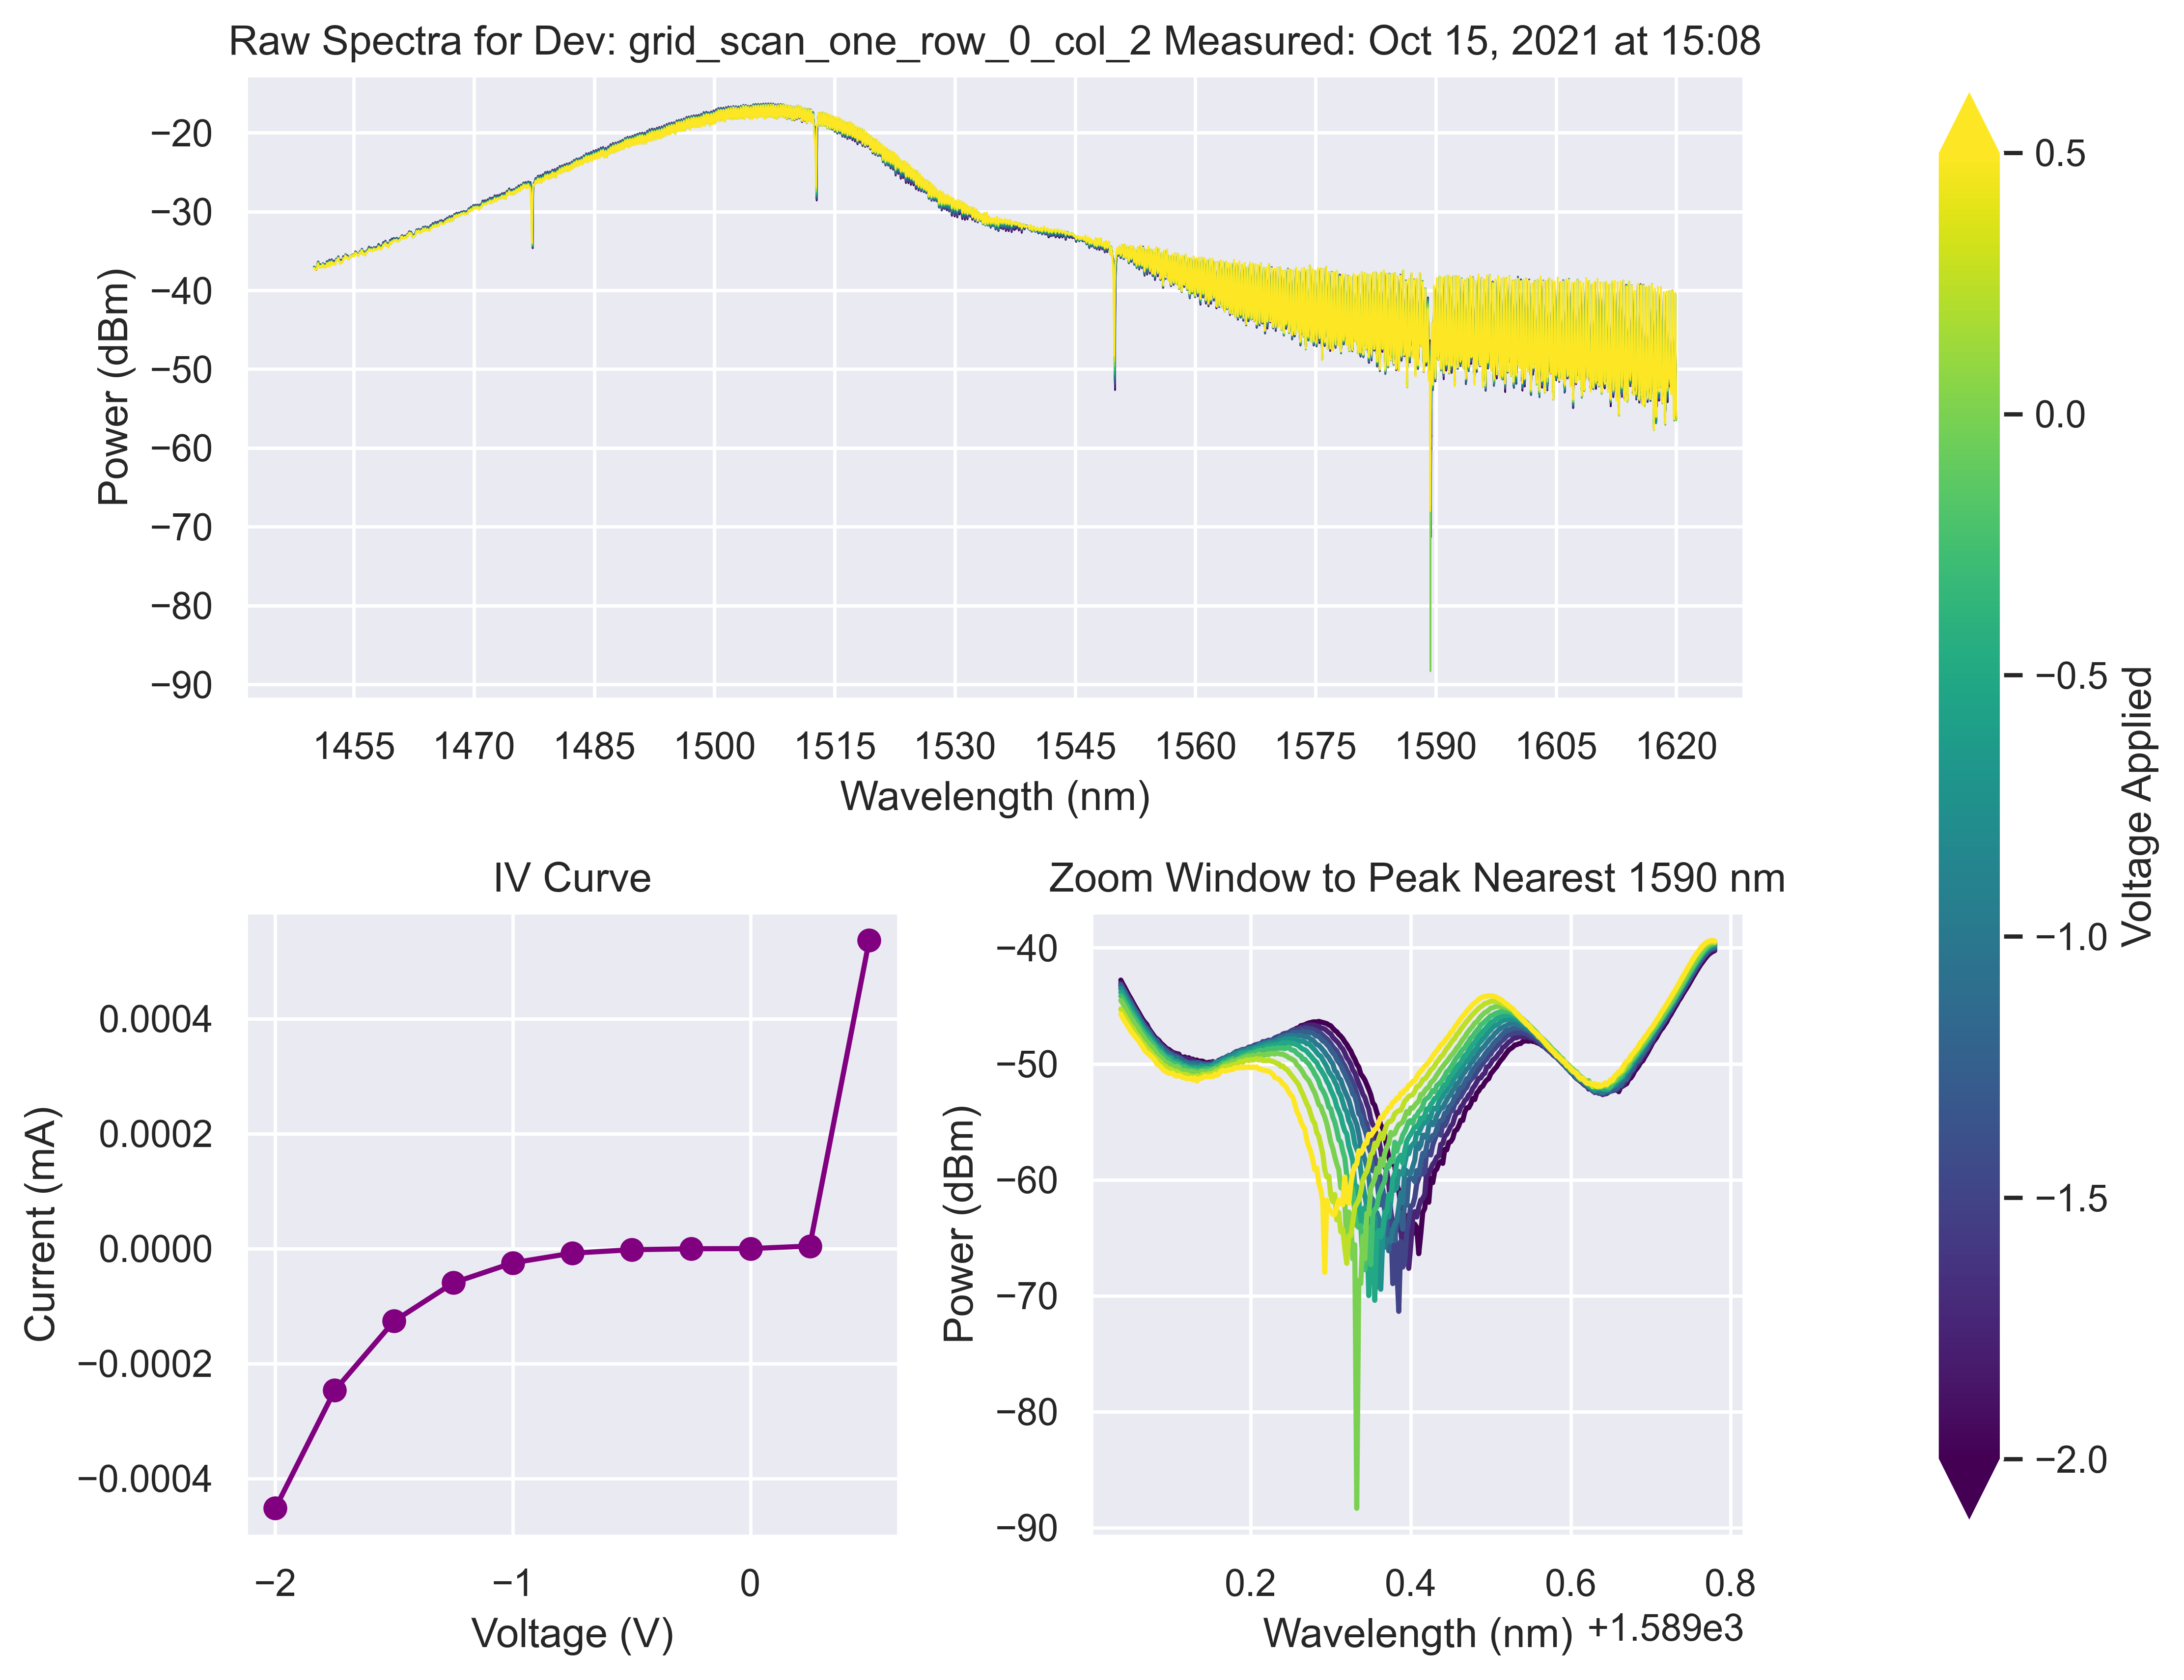

In [25]:
plot_VW(data, fit_order=8, ideal_peak_wl = 1590, zoom_span=0.75)

In [17]:
# extract peak near 1475nm wavelength

peak_wl1 = np.array([])
peak_pw1 = np.array([])
peak_top1 = np.array([])

peak_half1 = np.array([])
peak_left1 = np.array([])
peak_right1 = np.array([])

chan = 1
zoom_span = 1
prominence = 4.5
fit_order = 8
fsr = 15
ideal_peak_wl = 1475
save = False

wl = np.array(data['wavelengths'][0])
pw = np.array(data['powers'][0][chan - 1])

ridx = np.isfinite(wl) & np.isfinite(pw)

baseline = np.poly1d(np.polyfit(wl[ridx],pw[ridx],fit_order))

pw_bs = pw - baseline(wl) + max(baseline(wl)) - max(pw)
wl_per_args = wl[1] - wl[0]
peaks ,_ = find_peaks(-pw_bs, prominence = prominence, distance = int(fsr/wl_per_args))

idx = np.abs(wl[peaks] - ideal_peak_wl).argmin()
center_peak = peaks[idx]

span = int(0.5*zoom_span/wl_per_args)
start_zoom, stop_zoom = center_peak - span, center_peak + span

for i in range(len(data['wavelengths'])):
    wl = np.array(data['wavelengths'][i])
    pw = np.array(data['powers'][i][chan - 1])
    
    wl_zoom = wl[start_zoom:stop_zoom]
    pw_zoom = pw[start_zoom:stop_zoom]
    top = np.argwhere((wl_zoom<1477) | (wl_zoom>1477.5)).flatten()
    
    peak_wl1 = np.append(peak_wl1, wl_zoom[pw_zoom.argmin()])
    peak_pw1 = np.append(peak_pw1, pw_zoom[pw_zoom.argmin()])
    peak_top1 = np.append(peak_top1, np.mean(pw_zoom[top]))
    
    wl_left = wl[start_zoom:center_peak]
    wl_right = wl[center_peak:stop_zoom]
    peak_half1 = np.append(peak_half1, (peak_top1[i] + peak_pw1[i])/2)
    
    peak_left1 = np.append(peak_left1, wl_left[np.abs(pw[start_zoom:center_peak] - peak_half1[i]).argmin()])
    peak_right1 = np.append(peak_right1, wl_right[np.abs(pw[center_peak:stop_zoom] - peak_half1[i]).argmin()])
    
peak_depth1 = peak_top1 - peak_pw1
peak_width1 = peak_right1 - peak_left1

print('peak_wl1: ' + str(peak_wl1))
print('peak_pw1: ' + str(peak_pw1))
print('peak_depth1: ' + str(peak_depth1))
print('peak_width1: ' + str(peak_width1))

peak_wl1: [1477.3225 1477.3125 1477.305  1477.2975 1477.29   1477.28   1477.2725
 1477.2625 1477.25   1477.2325 1477.22  ]
peak_pw1: [-34.66828156 -34.63393021 -34.48968506 -34.44736862 -34.41939926
 -34.39852905 -34.34307861 -34.2358017  -34.20192337 -34.07148361
 -33.99619293]
peak_depth1: [8.51155092 8.43575007 8.28379587 8.16967419 8.10373137 8.03310281
 7.91811212 7.77949253 7.6562913  7.55425635 7.41910447]
peak_width1: [0.09   0.0925 0.0925 0.095  0.0975 0.11   0.12   0.13   0.1425 0.05
 0.175 ]


C:\Users\chane\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
# extract peak near 1515nm wavelength

peak_wl2 = np.array([])
peak_pw2 = np.array([])
peak_top2 = np.array([])

peak_half2 = np.array([])
peak_left2 = np.array([])
peak_right2 = np.array([])

chan = 1
zoom_span = 2
prominence = 4.5
fit_order = 8
fsr = 15
ideal_peak_wl = 1515
save = False

wl = np.array(data['wavelengths'][0])
pw = np.array(data['powers'][0][chan - 1])

ridx = np.isfinite(wl) & np.isfinite(pw)

baseline = np.poly1d(np.polyfit(wl[ridx],pw[ridx],fit_order))

pw_bs = pw - baseline(wl) + max(baseline(wl)) - max(pw)
wl_per_args = wl[1] - wl[0]
peaks ,_ = find_peaks(-pw_bs, prominence = prominence, distance = int(fsr/wl_per_args))

idx = np.abs(wl[peaks] - ideal_peak_wl).argmin()
center_peak = peaks[idx]

span = int(0.5*zoom_span/wl_per_args)
start_zoom, stop_zoom = center_peak - span, center_peak + span

for i in range(len(data['wavelengths'])):
    wl = np.array(data['wavelengths'][i])
    pw = np.array(data['powers'][i][chan - 1])
    
    wl_zoom = wl[start_zoom:stop_zoom]
    pw_zoom = pw[start_zoom:stop_zoom]
    top = np.argwhere((wl_zoom<1512.5) | (wl_zoom>1513)).flatten()
    
    peak_wl2 = np.append(peak_wl2, wl_zoom[pw_zoom.argmin()])
    peak_pw2 = np.append(peak_pw2, pw_zoom[pw_zoom.argmin()])
    peak_top2 = np.append(peak_top2, np.mean(pw_zoom[top]))
    
    wl_left = wl[start_zoom:center_peak]
    wl_right = wl[center_peak:stop_zoom]
    peak_half2 = np.append(peak_half2, (peak_top2[i] + peak_pw2[i])/2)
    
    peak_left2 = np.append(peak_left2, wl_left[np.abs(pw[start_zoom:center_peak] - peak_half2[i]).argmin()])
    peak_right2 = np.append(peak_right2, wl_right[np.abs(pw[center_peak:stop_zoom] - peak_half2[i]).argmin()])
    
peak_depth2 = peak_top2 - peak_pw2
peak_width2 = peak_right2 - peak_left2

print('peak_wl2: ' + str(peak_wl2))
print('peak_pw2: ' + str(peak_pw2))
print('peak_depth2: ' + str(peak_depth2))
print('peak_width2: ' + str(peak_width2))

peak_wl2: [1512.7525 1512.7475 1512.7375 1512.7325 1512.7275 1512.72   1512.7125
 1512.705  1512.695  1512.6825 1512.67  ]
peak_pw2: [-28.60956383 -28.46657753 -28.36168671 -28.21874428 -28.09183502
 -27.94129181 -27.78187752 -27.58917999 -27.39147186 -27.1750927
 -26.88873672]
peak_depth2: [10.38170529 10.2483773  10.12562144  9.99531386  9.85958096  9.68675799
  9.52250278  9.30684049  9.09484539  8.84259596  8.52439851]
peak_width2: [0.095  0.095  0.095  0.095  0.095  0.0975 0.1    0.1075 0.1175 0.1325
 0.2225]


C:\Users\chane\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
# extract peak near 1550nm wavelength

peak_wl3 = np.array([])
peak_pw3 = np.array([])
peak_top3 = np.array([])

peak_half3 = np.array([])
peak_left3 = np.array([])
peak_right3 = np.array([])

chan = 1
zoom_span = 2
prominence = 4.5
fit_order = 8
fsr = 15
ideal_peak_wl = 1550
save = False

wl = np.array(data['wavelengths'][0])
pw = np.array(data['powers'][0][chan - 1])

ridx = np.isfinite(wl) & np.isfinite(pw)

baseline = np.poly1d(np.polyfit(wl[ridx],pw[ridx],fit_order))

pw_bs = pw - baseline(wl) + max(baseline(wl)) - max(pw)
wl_per_args = wl[1] - wl[0]
peaks ,_ = find_peaks(-pw_bs, prominence = prominence, distance = int(fsr/wl_per_args))

idx = np.abs(wl[peaks] - ideal_peak_wl).argmin()
center_peak = peaks[idx]

span = int(0.5*zoom_span/wl_per_args)
start_zoom, stop_zoom = center_peak - span, center_peak + span

for i in range(len(data['wavelengths'])):
    wl = np.array(data['wavelengths'][i])
    pw = np.array(data['powers'][i][chan - 1])
    
    wl_zoom = wl[start_zoom:stop_zoom]
    pw_zoom = pw[start_zoom:stop_zoom]
    top = np.argwhere((wl_zoom<1549.75) | (wl_zoom>1550.25)).flatten()
    
    peak_wl3 = np.append(peak_wl3, wl_zoom[pw_zoom.argmin()])
    peak_pw3 = np.append(peak_pw3, pw_zoom[pw_zoom.argmin()])
    peak_top3 = np.append(peak_top3, np.mean(pw_zoom[top]))
    
    wl_left = wl[start_zoom:center_peak]
    wl_right = wl[center_peak:stop_zoom]
    peak_half3 = np.append(peak_half3, (peak_top3[i] + peak_pw3[i])/2)
    
    peak_left3 = np.append(peak_left3, wl_left[np.abs(pw[start_zoom:center_peak] - peak_half3[i]).argmin()])
    peak_right3 = np.append(peak_right3, wl_right[np.abs(pw[center_peak:stop_zoom] - peak_half3[i]).argmin()])
    
peak_depth3 = peak_top3 - peak_pw3
peak_width3 = peak_right3 - peak_left3

print('peak_wl3: ' + str(peak_wl3))
print('peak_pw3: ' + str(peak_pw3))
print('peak_depth3: ' + str(peak_depth3))
print('peak_width3: ' + str(peak_width3))

peak_wl3: [1549.975  1549.965  1549.955  1549.95   1549.9425 1549.9375 1549.9225
 1549.91   1549.9025 1549.8875 1549.8725]
peak_pw3: [-52.65431213 -52.4269371  -51.85611725 -51.51432037 -51.13881302
 -50.76522064 -50.56755829 -50.14260101 -49.59637833 -48.99372864
 -48.33516693]
peak_depth3: [17.517928   17.35130537 16.78031951 16.51036745 16.17316684 15.82870241
 15.66895435 15.23680421 14.71825198 14.06076121 13.39802296]
peak_width3: [0.0825 0.0825 0.085  0.085  0.0875 0.0925 0.1    0.1125 0.1275 0.1475
 0.0525]


C:\Users\chane\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
# extract peak near 1590nm wavelength

peak_wl4 = np.array([])
peak_pw4 = np.array([])
peak_top4 = np.array([])

peak_half4 = np.array([])
peak_left4 = np.array([])
peak_right4 = np.array([])

chan = 1
zoom_span = 2
prominence = 4.5
fit_order = 8
fsr = 15
ideal_peak_wl = 1590
save = False

wl = np.array(data['wavelengths'][0])
pw = np.array(data['powers'][0][chan - 1])

ridx = np.isfinite(wl) & np.isfinite(pw)

baseline = np.poly1d(np.polyfit(wl[ridx],pw[ridx],fit_order))

pw_bs = pw - baseline(wl) + max(baseline(wl)) - max(pw)
wl_per_args = wl[1] - wl[0]
peaks ,_ = find_peaks(-pw_bs, prominence = prominence, distance = int(fsr/wl_per_args))

idx = np.abs(wl[peaks] - ideal_peak_wl).argmin()
center_peak = peaks[idx]

span = int(0.5*zoom_span/wl_per_args)
start_zoom, stop_zoom = center_peak - span, center_peak + span

for i in range(len(data['wavelengths'])):
    wl = np.array(data['wavelengths'][i])
    pw = np.array(data['powers'][i][chan - 1])
    
    wl_zoom = wl[start_zoom:stop_zoom]
    pw_zoom = pw[start_zoom:stop_zoom]
    top = np.argwhere((wl_zoom<1589.25) | (wl_zoom>1589.5)).flatten()
    
    peak_wl4 = np.append(peak_wl4, wl_zoom[pw_zoom.argmin()])
    peak_pw4 = np.append(peak_pw4, pw_zoom[pw_zoom.argmin()])
    peak_top4 = np.append(peak_top4, np.mean(pw_zoom[top]))
    
    wl_left = wl[start_zoom:center_peak]
    wl_right = wl[center_peak:stop_zoom] 
    peak_half4 = np.append(peak_half4, (peak_top4[i] + peak_pw4[i])/2)
    
    peak_left4 = np.append(peak_left4, wl_left[np.abs(pw[start_zoom:center_peak] - peak_half4[i]).argmin()])
    peak_right4 = np.append(peak_right4, wl_right[np.abs(pw[center_peak:stop_zoom] - peak_half4[i]).argmin()])

peak_depth4 = peak_top4 - peak_pw4
peak_width4 = peak_right4 - peak_left4

print('peak_wl4: ' + str(peak_wl4))
print('peak_pw4: ' + str(peak_pw4))
print('peak_depth4: ' + str(peak_depth4))
print('peak_width3: ' + str(peak_width4))

peak_wl4: [1589.41   1589.3975 1589.385  1589.3775 1589.3625 1589.3625 1589.355
 1589.3425 1589.3325 1589.32   1589.2925]
peak_pw4: [-66.37620544 -67.6446991  -71.35069275         -inf -67.42378998
 -69.4437561  -70.39901733 -67.75940704 -88.33505249 -67.21356964
 -67.99856567]
peak_depth4: [19.39342494 20.6931154  24.44146915         inf 20.58871386 22.64348807
 23.60502557 20.96691663 41.53540313 20.35850854 21.10764869]
peak_width3: [0.0825 0.075  0.0525 0.0325 0.075  0.075  0.0275 0.095  0.0825 0.2775
 0.2925]


C:\Users\chane\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-27-e979d5b7d60b>:52: RuntimeWarning: invalid value encountered in subtract
  peak_left4 = np.append(peak_left4, wl_left[np.abs(pw[start_zoom:center_peak] - peak_half4[i]).argmin()])


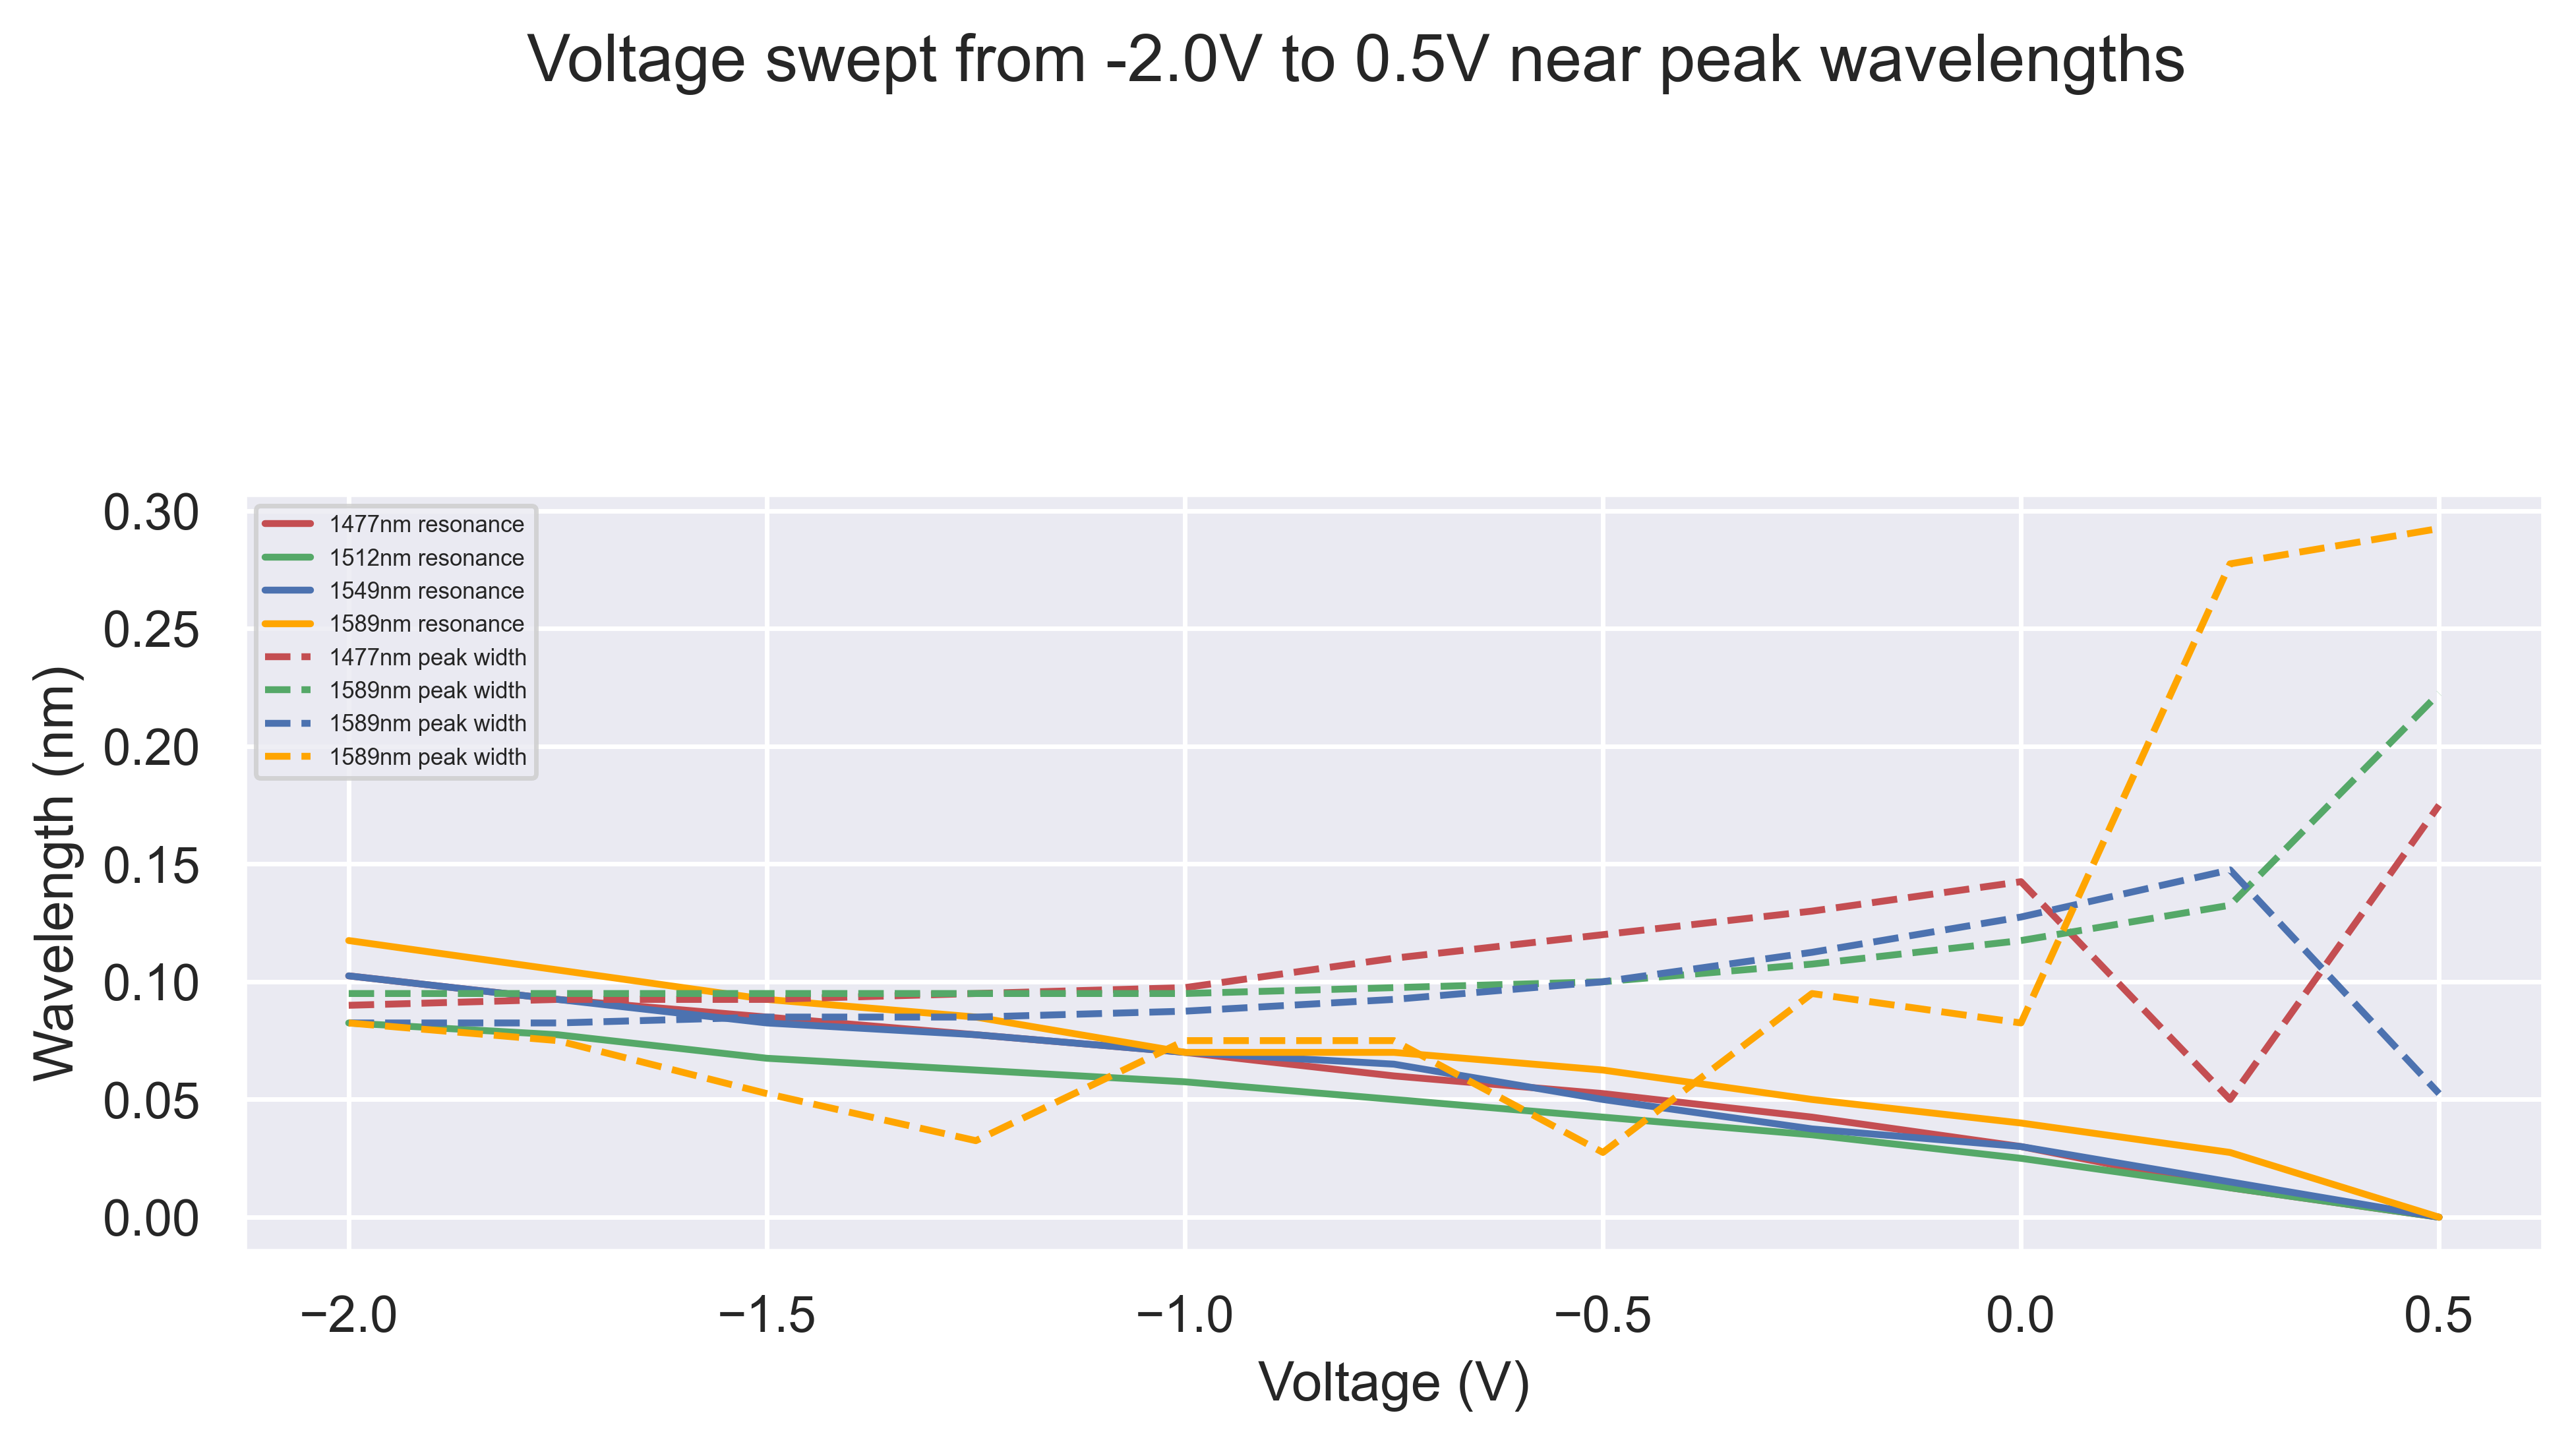

In [28]:
# plot change in wavelength peak as voltage is swept

from scipy.interpolate import interp1d

fig = plt.figure( figsize = (9,14), dpi = 500 )
fig.suptitle('Voltage swept from -2.0V to 0.5V near peak wavelengths')
colors = plt.cm.cividis(np.linspace(0,1,4))

ax = fig.add_subplot(411)

peak_res1 = peak_wl1 - min(peak_wl1)
peak_res2 = peak_wl2 - min(peak_wl2)
peak_res3 = peak_wl3 - min(peak_wl3)
peak_res4 = peak_wl4 - min(peak_wl4)

ax.plot(data['voltages'], peak_res1, color='r', label='1477nm resonance')
ax.plot(data['voltages'], peak_res2, color='g', label='1512nm resonance')
ax.plot(data['voltages'], peak_res3, color='b', label='1549nm resonance')
ax.plot(data['voltages'], peak_res4, color='orange', label='1589nm resonance')

ax.plot(data['voltages'], peak_width1, '--', color='r', label='1477nm peak width')
ax.plot(data['voltages'], peak_width2, '--', color='g', label='1589nm peak width')
ax.plot(data['voltages'], peak_width3, '--', color='b', label='1589nm peak width')
ax.plot(data['voltages'], peak_width4, '--', color='orange', label='1589nm peak width')

ax.set_ylabel('Wavelength (nm)')
ax.set_xlabel('Voltage (V)')
ax.legend(loc='upper left', prop={'size': 5});

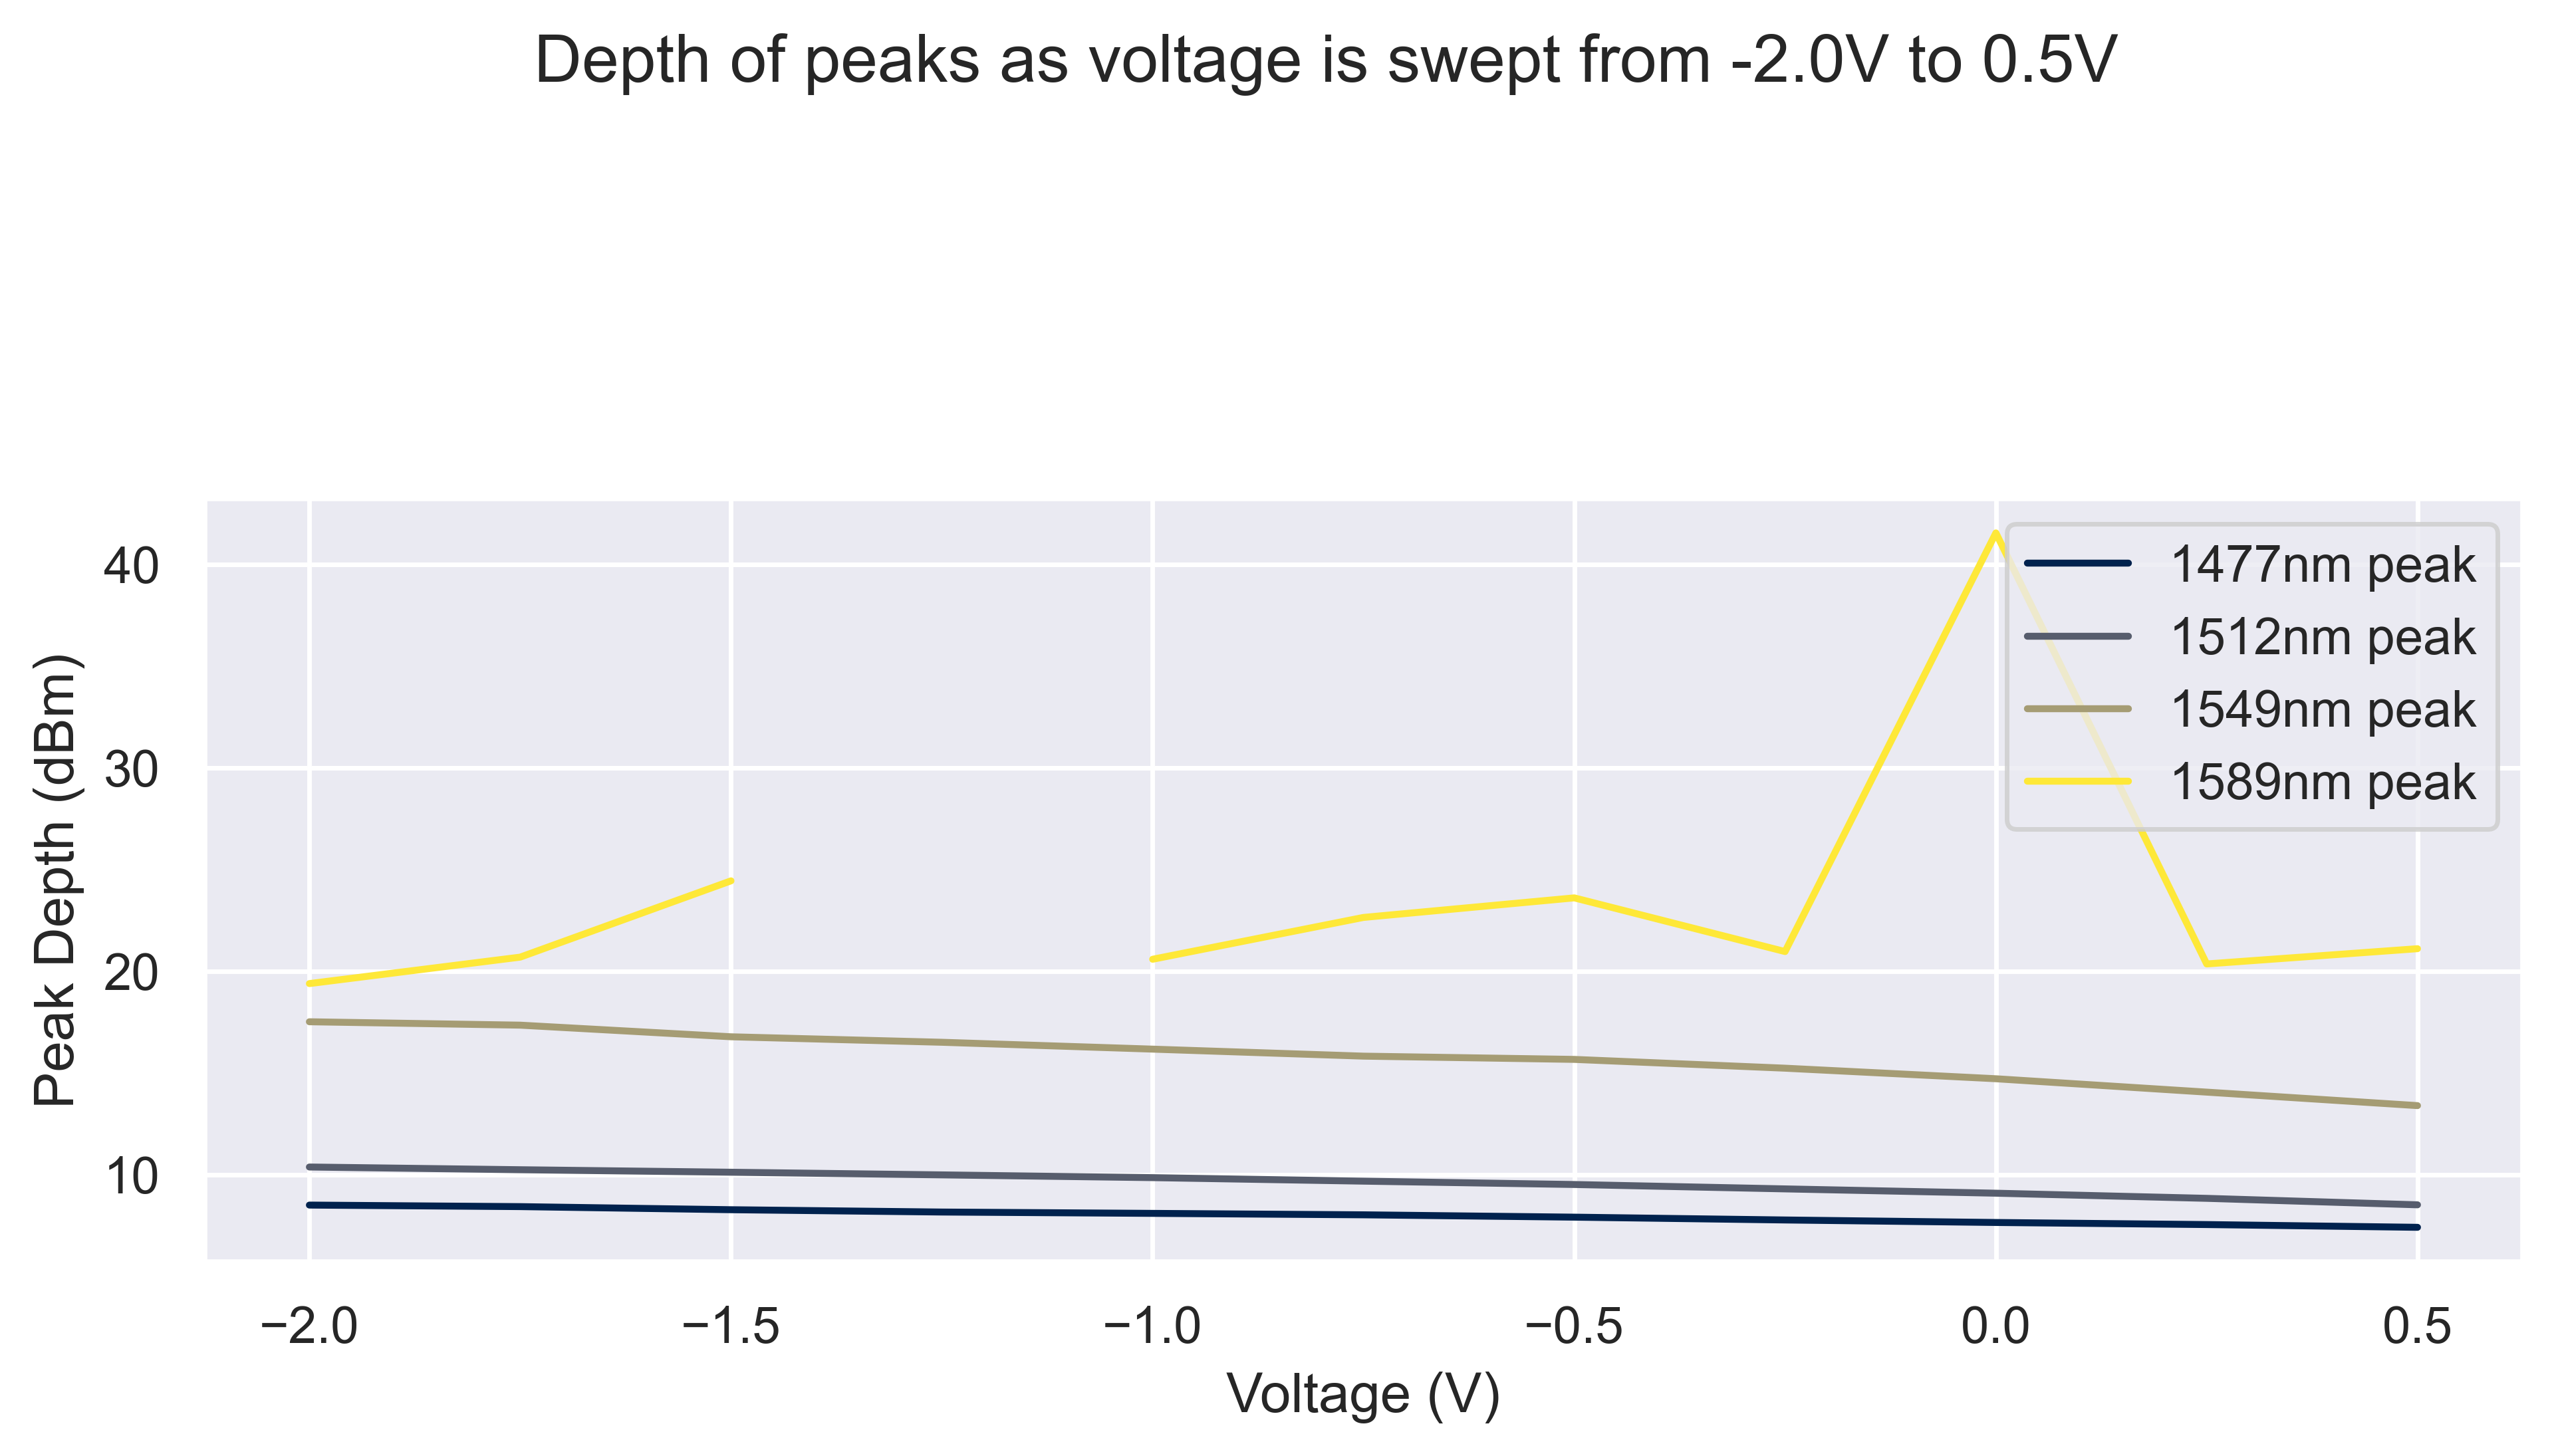

In [29]:
# plot depth of peaks as voltage is swept

fig = plt.figure( figsize = (9,14), dpi = 500 )
fig.suptitle('Depth of peaks as voltage is swept from -2.0V to 0.5V')
colors = plt.cm.cividis(np.linspace(0,1,4))

ax = fig.add_subplot(411)

ax.plot(data['voltages'], peak_depth1, color=colors[0], label='1477nm peak')
ax.plot(data['voltages'], peak_depth2, color=colors[1], label='1512nm peak')
ax.plot(data['voltages'], peak_depth3, color=colors[2], label='1549nm peak')
ax.plot(data['voltages'], peak_depth4, color=colors[3], label='1589nm peak')
ax.set_ylabel('Peak Depth (dBm)')
ax.set_xlabel('Voltage (V)')
ax.legend(loc='upper right');